## Description of notebook

In this notebook, an usupervised bias detection tool is applied on synthetic data of the CUB process from 2014. The synthetic dataset (n=20.000) reflects group level characteristics of students that were registered to receive a college grant on 01-02-2014 by the Dutch Executive Education Agency (DUO). A clustering algorithm is applied to identify groups of similar students that are treated differently.

## Table of contents

0. Import libraries and data
1. Data processing
2. Clustering
3. Analysis of cluster with most bias
4. Analysis of all identifief clusters

## 0. Import libraries and data

In [1]:
import warnings
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import chi2_contingency, chi2
from sklearn.preprocessing import LabelEncoder
from unsupervised_bias_detection.clustering import BiasAwareHierarchicalKModes
warnings.filterwarnings('ignore')

In [2]:
# Load data
df = pd.read_csv('Table1_SD_20k.csv', sep=",", index_col='Unnamed: 0')

In [3]:
df.head()

,Education,Age,Distance,Risk category,Outcome house visit,Outcome appeal
0,MBO 3-4,19-20,5-10km,5,Not available,NaN
1,WO,25-50,50-500km,4,Not available,NaN
2,MBO 3-4,19-20,50-500km,5,Not available,NaN
3,WO,21-22,20-50km,6,Not available,NaN
4,WO,19-20,50-500km,2,Not available,NaN


In [4]:
df.shape

(20000, 6)

## 1. Data processing

In [5]:
# mapping high risk categories to 0 (low metric value) and low risk categories to 1 (high metric value)
mapping = {6:0, 5:0, 4:1, 3:1, 2:1, 1:1}
df['Risk category'] = df['Risk category'].map(mapping)

In [6]:
# encode columns values to numerical values
le1, le2, le3 = LabelEncoder(), LabelEncoder(), LabelEncoder()
df['Education'] = le1.fit_transform(df['Education'])
df['Age'] = le2.fit_transform(df['Age'])
df['Distance'] = le3.fit_transform(df['Distance'])

In [7]:
df.head()

,Education,Age,Distance,Risk category,Outcome house visit,Outcome appeal
0,2,1,6,0,Not available,NaN
1,3,4,7,1,Not available,NaN
2,2,1,7,0,Not available,NaN
3,3,2,5,0,Not available,NaN
4,3,1,7,1,Not available,NaN


## 2. Clustering

In [8]:
features=['Education','Age','Distance']
X = df[features]
y = df['Risk category']
hbac = BiasAwareHierarchicalKModes(n_iter=20, min_cluster_size=750).fit(X, y)

In [9]:
hbac.n_clusters_

5

In [10]:
hbac.scores_

array([ 0.01711251,  0.00048727, -0.00587807, -0.02072472, -0.0364168 ])

## 3. Analysis of cluster with most bias

In [11]:
# Invert numerical labels back to original categorical labels
df['Education'] = le1.inverse_transform(df['Education'])
df['Age'] = le2.inverse_transform(df['Age'])
df['Distance'] = le3.inverse_transform(df['Distance'])

In [12]:
# cluster with most bias has label 0
df_most_biased_cluster = df[hbac.labels_ == 0]
df_other = df[hbac.labels_ != 0]

In [13]:
def stat_df_cat(df1, df2, features):
    '''
    For categorical data only: Takes dataframe of cluster 
    with highest bias and dataframe of the rest of the 
    datasets and computes differency in frequency, should 
    return 95% confidence intervals based on Chi2-test in
    the future.
    '''   

    # initialize dictionaries
    diff_dict = {}
    # chi2_dict = {}
    # cramer_dict = {}
    # CI_dict_left = {}
    # CI_dict_right = {}

    # range through features
    for feat in features:
        df1_feat = df1[feat].value_counts()
        df2_feat = df2[feat].value_counts()

        # merge dfs on the feat column
        merged_df = pd.merge(df1_feat, df2_feat, on=feat, suffixes=('_df1', '_df2'))
        merged_df['diff'] = merged_df['count_df1']-merged_df['count_df2']
        diff_dict[feat] = merged_df['diff'].to_dict()

        # # Create a contingency table
        # contingency_table = merged_df[['count_df1', 'count_df2']].values
        # print(contingency_table)

        # # Perform chi-square test
        # chi2_stat, p_value, dof, expected = chi2_contingency(contingency_table)

        # # Calculate Cramér's V
        # n = contingency_table.sum()
        # phi2 = chi2_stat/n
        # r, k = contingency_table.shape
        # cramers_v = np.sqrt(phi2 / min(k-1, r-1))

        # # Compute 95% confidence interval for Cramér's V
        # alpha = 0.05
        # chi2_critical = chi2.ppf(1 - alpha, dof)
        # ci_lower = np.sqrt((phi2 - (chi2_critical / (2*n))) / min(k-1, r-1))
        # ci_upper = np.sqrt((phi2 + (chi2_critical / (2*n))) / min(k-1, r-1))

        # # attach to dictionaries
        # chi2_dict[feat] = p_value
        # cramer_dict[feat]  = cramers_v
        # CI_dict_left[feat] = ci_lower
        # CI_dict_right[feat] = ci_upper
        
    # store results in dataframe
    pd.set_option('display.float_format', lambda x: '%.5f' % x)
    dataframes = [pd.DataFrame(data, index=['Difference']) for key, data in diff_dict.items()]
    cluster_analysis_df = pd.concat(dataframes, axis=1).T
    # cluster_analysis_df = pd.DataFrame([diff_dict['Education'], chi2_dict, CI_dict_left, CI_dict_right]).T
    # cluster_analysis_df.columns = ['difference','p-value','[0.025','0.975]']
    # cluster_analysis_df = cluster_analysis_df.sort_values('p-value',ascending=[True])
    # n_rows = cluster_analysis_df.shape[0]

    # # Get errors; (coef - lower bound of conf interval)
    # cluster_analysis_df['errors'] = cluster_analysis_df['difference'] - cluster_analysis_df['[0.025']
    # cluster_analysis_df = cluster_analysis_df.iloc[0:n_rows,]
    # cluster_analysis_df['num'] = [int(i) for i in np.linspace(n_rows-1,0,n_rows)]

    # cluster_analysis_df = cluster_analysis_df.reset_index()
    
    # return(cluster_analysis_df)
    return(cluster_analysis_df)
    # return(diff_dict, chi2_dict, cramer_dict, CI_dict_left, CI_dict_right)

In [14]:
diff_df = stat_df_cat(df_most_biased_cluster,df_other,features=features)
diff_df

,Difference
HBO,4323
WO,-3458
MBO 3-4,326
MBO 1-2,113
21-22,6041
19-20,-3497
23-24,-1144
25-50,-80
15-18,-16
50-500km,2759


In [15]:
diff_df.index

Index(['HBO', 'WO', 'MBO 3-4', 'MBO 1-2', '21-22', '19-20', '23-24', '25-50',
       '15-18', '50-500km', '20-50km', 'Not available', '2-5km', '10-20km',
       '5-10km', '1-2km', '1m-1km', '0km'],
      dtype='object')

Text(0, 0.5, 'Feature')

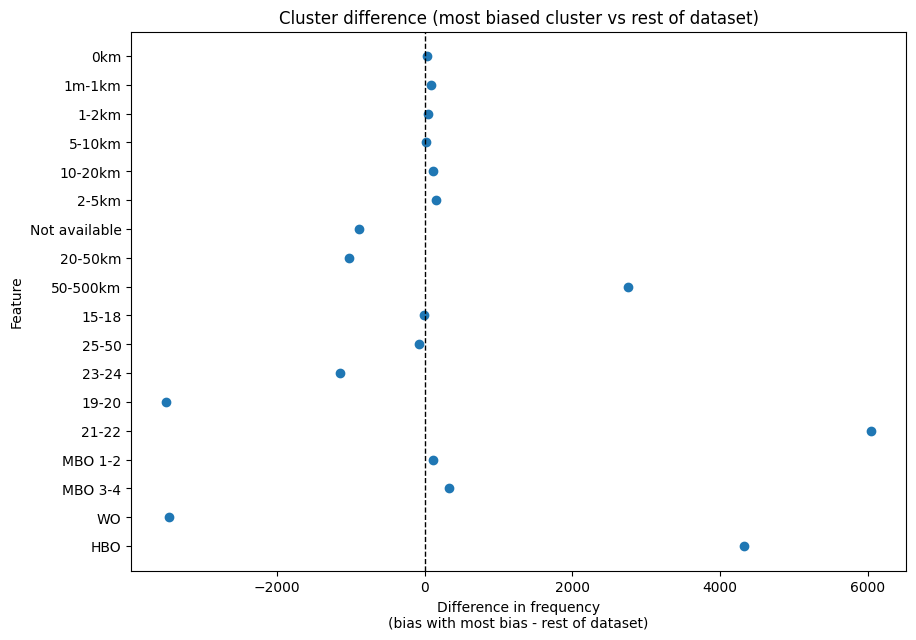

In [16]:
# Create the scatter plot
fig, ax = plt.subplots(figsize=(10, 7))
ax.scatter(diff_df['Difference'], diff_df.index)

# Line to define zero on the x-axis
ax.axvline(x=0, linestyle='--', color='black', linewidth=1)

# Adding title and labels
plt.title('Cluster difference (most biased cluster vs rest of dataset)')
plt.xlabel('Difference in frequency\n(bias with most bias - rest of dataset)')
plt.ylabel('Feature')

## 4. Analysis of all identified clusters

In [17]:
df_cluster1 = df[hbac.labels_ == 1]
df_cluster2 = df[hbac.labels_ == 2]
df_cluster3 = df[hbac.labels_ == 3]
df_cluster4 = df[hbac.labels_ == 4]

df_most_biased_cluster['Cluster'] = '0'
df_cluster1['Cluster'] = '1'
df_cluster2['Cluster'] = '2'
df_cluster3['Cluster'] = '3'
df_cluster4['Cluster'] = '4'

In [18]:
full_df = pd.concat([df_most_biased_cluster, df_cluster1, df_cluster2, df_cluster3, df_cluster4], ignore_index=True)
full_df.head()

,Education,Age,Distance,Risk category,Outcome house visit,Outcome appeal,Cluster
0,MBO 3-4,19-20,50-500km,0,Not available,NaN,0
1,HBO,19-20,50-500km,1,Not available,NaN,0
2,MBO 3-4,15-18,50-500km,1,Not available,NaN,0
3,MBO 1-2,15-18,10-20km,0,Not available,NaN,0
4,WO,21-22,2-5km,0,Not available,NaN,0


In [20]:
df_most_biased_cluster['Risk category'].mean()

0.47390161472024034

<Axes: ylabel='Cluster'>

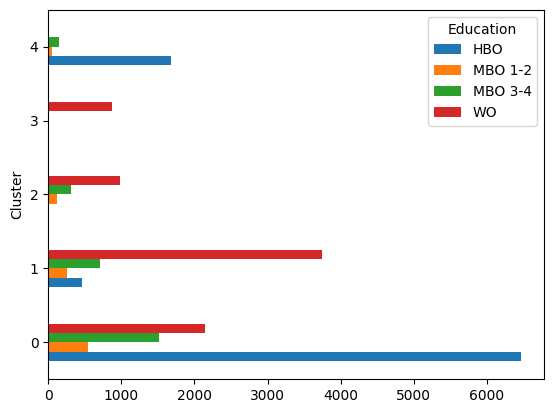

In [21]:
full_df.groupby('Cluster')['Education'].value_counts().unstack().plot.barh()

<Axes: ylabel='Cluster'>

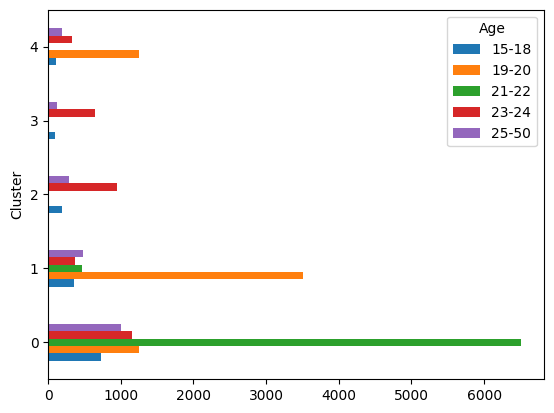

In [22]:
full_df.groupby('Cluster')['Age'].value_counts().unstack().plot.barh()

<Axes: ylabel='Cluster'>

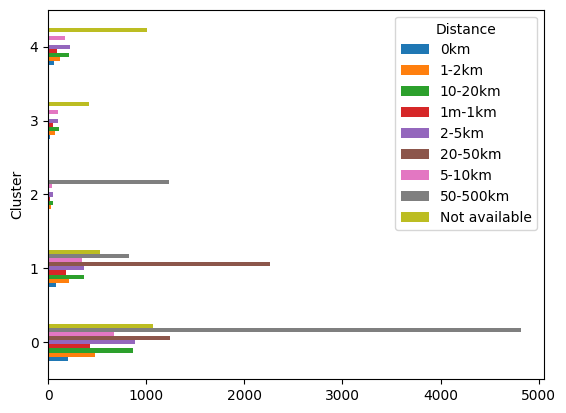

In [23]:
full_df.groupby('Cluster')['Distance'].value_counts().unstack().plot.barh()